## 셋업


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Input, Dense, Flatten, Bidirectional

In [2]:

TRAINING_SIZE = 50000   # 데이터의 갯수
DIGITS = 3              # 덧셈에 사용될 숫자 자리수
REVERSE = True          # 입력 문자열의 역순 여부. 

# 입력 문자열의 최대 길이.
#      = 숫자길이 '+'   숫자길이 '='  정답숫자길이
MAXLEN = DIGITS +  1  + DIGITS +  1 + (DIGITS+1)


# 데이터

## 입력 문제와 정답여부 생성


In [3]:
MAX_ERROR = 10
chars = "0123456789+= "

questions = []
expecteds = []

while len(questions) < TRAINING_SIZE:

    a = np.random.randint(1000)
    b = np.random.randint(1000)
    # a = 123
    # b = 45

    error = np.random.randint(2)
    # error = 1

    s = a+b+error
    # s = 123+45+1 = 169

    q = "{}+{}={}".format(a, b, s)
    # q = '123+45=169'

    query = q.ljust(MAXLEN, ' ')
    # query = '123+45=169  '

    if REVERSE:
        query = query[::-1]
        # query = ' 961=54+321'

    correct = 1 - error
    questions.append(query)
    expecteds.append(correct)

print("Total questions:", len(questions))


Total questions: 50000


In [4]:
for i in range(10):
  print("'"+questions[i]+"' --->", expecteds[i])

'  586=795+88' ---> 1
'9401=052+997' ---> 1
' 8401=35+499' ---> 0
'6321=959+672' ---> 0
'0911=228+763' ---> 0
'  636=16+575' ---> 1
' 297=791+495' ---> 0
'9621=756+216' ---> 1
'  922=802+12' ---> 1
'8521=235+627' ---> 1


## 데이터를 벡터화 하기

인코딩 디코딩을 위한 유틸 클래스 CharacterTable

In [5]:
class CharacterTable:

    # ' ', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '='
    #  0    1    2    3    4    5    6    7    8    9    10   11   12

    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars)) # '+' ->  1
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars)) #  1  -> '+'

    def encode(self, C, num_rows=MAXLEN):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C): # 각 자리 문자마다
            x[i, self.char_indices[c]] = 1 # 각 줄의 index만 1로 만든다. one-hot encoding한다.
        return x

    def decode(self, x):
        x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)


In [6]:
ctable = CharacterTable(chars)

다음은 인코딩, 디코딩 예이다.

In [7]:
# 원 문자열
org_str = '  655=123+45'
print(f"org_str='{org_str}'")

# 인코딩된 값
encoded = ctable.encode(org_str)
# [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   ' '
#  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   ' '
#  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]   '6'
#  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]   '5'
#  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]   '5'
#  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]   '='
#  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   '1'
#  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]   '2'
#  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]   '3'
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   '+'
#  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]   '4'
#  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]  '5'
print(f"encoded=\n{encoded}")
print(f"encoded.shape={encoded.shape}")

# 다시 디코딩해서 원복한 값
decoded = ctable.decode(encoded)
print(f"decoded='{decoded}'")

org_str='  655=123+45'
encoded=
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
encoded.shape=(12, 13)
decoded='  655=123+45'


In [8]:
# DIGITS = 3
# MAXLEN = DIGITS + 1 + DIGITS + 1 + (DIGITS+1)
# chars = '0123456789+='
x = np.zeros((len(questions), MAXLEN, len(chars)))
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence)

y = np.array(expecteds)
print(x.shape)
print(y.shape)

(50000, 12, 13)
(50000,)


In [9]:
split_at = int(len(x)*0.9)
(train_x, test_x) = x[:split_at], x[split_at:]
(train_y, test_y) = y[:split_at], y[split_at:]

print("Training Data:")
print(train_x.shape)
print(train_y.shape)

print("Test Data:")
print(test_x.shape)
print(test_y.shape)


Training Data:
(45000, 12, 13)
(45000,)
Test Data:
(5000, 12, 13)
(5000,)


In [10]:
print("train_x[0]\n", train_x[0])
print()
print("train_y[0]\n", train_y[0])

train_x[0]
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

train_y[0]
 1


준비된 데이터는 인코딩된 값들입니다. 디코딩에서 본 원 문자열은 다음과 같습니다.

In [11]:
for i in range(10):
  print("'"+ctable.decode(train_x[i])+"' -> "+str(train_y[i]))

'  586=795+88' -> 1
'9401=052+997' -> 1
' 8401=35+499' -> 0
'6321=959+672' -> 0
'0911=228+763' -> 0
'  636=16+575' -> 1
' 297=791+495' -> 0
'9621=756+216' -> 1
'  922=802+12' -> 1
'8521=235+627' -> 1


# 학습


## 모델 정의


In [16]:
input_shape = (MAXLEN, len(chars))
model = keras.Sequential()
model.add(Input(input_shape))
model.add(LSTM(128))
model.add(Dense(20))
model.add(Dense(2, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72704     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 75,326
Trainable params: 75,326
Non-trainable params: 0
_________________________________________________________________


## 학습 실행

In [17]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.1)

Epoch 1/30
317/317 [==============================] - 3s 5ms/step - loss: 0.6938 - accuracy: 0.5027 - val_loss: 0.6938 - val_accuracy: 0.4887
Epoch 2/30
317/317 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5049 - val_loss: 0.6937 - val_accuracy: 0.4971
Epoch 3/30
317/317 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5045 - val_loss: 0.6939 - val_accuracy: 0.4936
Epoch 4/30
317/317 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6937 - val_accuracy: 0.4971
Epoch 5/30
317/317 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy: 0.4916
Epoch 6/30
317/317 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6937 - val_accuracy: 0.4933
Epoch 7/30
317/317 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6938 - val_accuracy: 0.4929
Epoch 

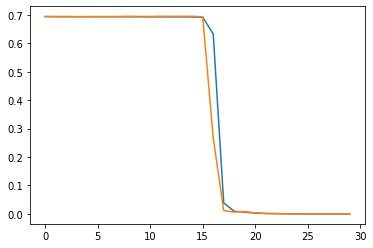

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

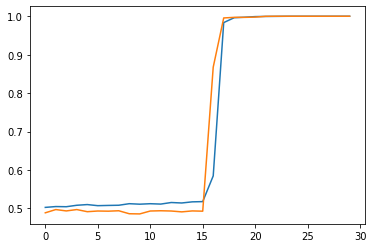

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# 평가

In [20]:
loss, acc = model.evaluate(test_x, test_y)
print("loss =", loss)
print("acc =", acc)

157/157 [==============================] - 0s 2ms/step - loss: 5.7734e-04 - accuracy: 0.9996
loss = 0.0005773439770564437
acc = 0.9995999932289124


In [21]:
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
for i in range(10):
  print("'"+ctable.decode(test_x[i])+"'  ----> ", predicted[i])




' 357=755+691'  ---->  1
'1101=061+058'  ---->  0
'7681=059+619'  ---->  0
'8031=747+165'  ---->  1
'  603=252+45'  ---->  1
' 579=882+686'  ---->  0
'  281=16+121'  ---->  1
'3731=935+338'  ---->  0
'0301=438+591'  ---->  0
'2421=408+834'  ---->  1
